In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline

from utils.plotting import despine, cm2inch
from utils.general import make_sure_path_exists
from utils.descriptives import compute_gaze_influence_score, compute_p_last_gaze_choice

# Descriptives & data

In [2]:
# directories
data_dir = '../data/'
figure_dir = '../figures/'

# make sure figure dir exists
make_sure_path_exists(figure_dir)

# choice set sizes
setsizes = np.array([9, 16, 25, 36])
# colors for each set size
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# load response data
data =[]
for setsize in setsizes:
    df_setsize = pd.read_csv(data_dir+'summary_files/setsize-{}_desc-data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize)
data = pd.concat(data, sort=True)

# add RT in seconds
data['rt_s'] = data['rt'].values / 1000.
    
# read out subject IDs
subjects = np.unique(data.subject)
n_subjects = subjects.size
    
# load gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,cumulative_gaze_0,cumulative_gaze_1,cumulative_gaze_10,cumulative_gaze_11,cumulative_gaze_12,cumulative_gaze_13,cumulative_gaze_14,...,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial,rt_s
0,1.0,1.0,1,0.072271,0.153518,NaN,NaN,NaN,NaN,NaN,...,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2,8.468078
1,1.0,1.0,0,0.074341,0.073074,NaN,NaN,NaN,NaN,NaN,...,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3,4.734945
2,1.0,1.0,1,0.068776,0.124769,NaN,NaN,NaN,NaN,NaN,...,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7,7.822484
3,1.0,1.0,3,0.133512,0.060818,NaN,NaN,NaN,NaN,NaN,...,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9,5.557554
4,1.0,1.0,4,0.060270,0.072763,NaN,NaN,NaN,NaN,NaN,...,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14,9.125540


In [4]:
gaze_data.head()

,choice,dur,gaze_num,is_first,is_last,is_last_to_choice,is_returning,item,item_value,onset,returning_gaze_count,setsize,stimulus,subject,trial
0,1,552.0,1.0,1.0,0.0,1.0,0.0,4,0.0,76.0,0.0,9,nr62.png,0,2
1,1,188.0,2.0,0.0,0.0,1.0,0.0,3,0.0,678.0,0.0,9,nr48.png,0,2
2,1,260.0,3.0,0.0,0.0,1.0,0.0,7,0.0,922.0,0.0,9,nr113.png,0,2
3,1,348.0,4.0,0.0,0.0,1.0,0.0,1,2.0,1238.0,0.0,9,nr10.png,0,2
4,1,326.0,5.0,0.0,0.0,1.0,0.0,0,0.0,1662.0,0.0,9,nr91.png,0,2


# Figure 4-figure supplement 1

In [5]:
def compute_associations_figure_4F(data, gaze_data, setsizes=np.array([9,16,25,36]), verbose=False):
    """Compute Spearman rank correlations for associations  
    shown in Fig. 4 F of the manuscript. 
    
    Args:
        data (dataframe): choice data   
        gaze_data (dataframe): gaze data
        setsizes (array of int): choice set size conditions
        verbose (bool): whether to print results of each
            association test
                
    Returns:
        matrix with correlation coefficients and p-values:
        (var A x var B x (correlation coefficient, p-value))
    """
    
    # 1. Seen items count vs set-size
    data['frac_items_seen'] = (data['seen_items_count'] / data['setsize']).values.astype(np.float)
    sub_frac_items_seen = np.concatenate(
        [data.groupby(['setsize', 'subject']).frac_items_seen.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 2. Response time vs set-size
    sub_rt_means = np.concatenate(
        [data.groupby(['setsize', 'subject']).rt_s.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 3. P(choose best seen item )
    sub_best_seen_chosen_means = np.concatenate(
        [data.groupby(['setsize','subject']).best_seen_chosen.mean()[s][:,None] for s in setsizes],
        axis=1)
    
    # 4. P(last gaze to choice)
    (sub_p_last_gaze_choice_means,
     p_last_gaze_choice_means,
     p_last_gaze_choice_sems) = compute_p_last_gaze_choice(data, gaze_data)
    
    # 5. Gaze Influence on choice probability
    sub_gaze_influence_scores = []
    for setsize in setsizes:
        sub_gaze_influence_scores.append(compute_gaze_influence_score(data[data['setsize']==setsize].copy()))
    sub_gaze_influence_scores = np.concatenate([s[:,None] for s in sub_gaze_influence_scores],
                                               axis=1)
    
    # Make df (average over setsizes)
    assoc_df = pd.DataFrame({'subject': subjects,
                             'frac_items_seen': sub_frac_items_seen.mean(axis=1),
                             'RT': sub_rt_means.mean(axis=1),
                             'best_chosen': sub_best_seen_chosen_means.mean(axis=1),
                             'last_gaze_to_choice': sub_p_last_gaze_choice_means.mean(axis=1),
                             'gaze_influence': sub_gaze_influence_scores.mean(axis=1)})
    
    # Define combinations
    xs = ['best_chosen', 'best_chosen', 'best_chosen', 'best_chosen', 'best_chosen',
          'frac_items_seen', 'frac_items_seen', 'frac_items_seen', 'frac_items_seen',
          'RT', 'RT', 'RT',
          'last_gaze_to_choice', 'last_gaze_to_choice',
          'gaze_influence']
    ys = ['best_chosen', 'frac_items_seen', 'RT', 'last_gaze_to_choice', 'gaze_influence',
          'frac_items_seen', 'RT', 'last_gaze_to_choice', 'gaze_influence',
          'RT', 'last_gaze_to_choice', 'gaze_influence',
          'last_gaze_to_choice', 'gaze_influence',
          'gaze_influence']
    pos = [(0,0), (1,0), (2,0), (3,0), (4,0),
           (1,1), (2,1), (3,1), (4,1),
           (2,2), (3,2), (4,2),
           (3,3), (4,3),
           (4,4)]
    
    if verbose:
        print('\nCorrelation coefficients:')
    
    # Compute correlations
    association_mat = np.zeros((5,5,2)) * np.nan
    for x, y, (xi, yi) in zip(xs, ys, pos):
        if verbose:
            print('\n{} ~ {}'.format(x,y))
        r, p = spearmanr(assoc_df[x], assoc_df[y])
        if verbose:
            print('Spearman r = {}, p = {}'.format(r, p))
        association_mat[xi, yi] = r, p
    
    return association_mat

In [6]:
def _scatter(x, y, ax, color, label=None):
    """nice scatters"""
    ax.scatter(x, y, marker='o', color='none', edgecolor=color, 
               linewidth=0.75, alpha=1, s=20)
    ax.scatter(x, y, marker='o', color=color, alpha=0.2,
               linewidth=0, s=20, label=label)

In [7]:
def _annotation(i,j,corr_mat):
    """spearman correlation annotation"""
    rval, pval = corr_mat[i,j,:]
    if pval < 0.0001:
        p_string = r'$P < 0.0001$'
    else:
        p_string = r'$P = {}$'.format(np.round(pval, 4))
    annotation = (r'$\rho(48)$'+r'$ = {:.3f}$, '.format(rval)) + p_string
    return annotation

In [8]:
def figure_4_figure_supplement_1(data, gaze_data, colors=['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral'], 
              fontsize=8, dpi=300):
    """Create Figure 4-figure supplement 1.
    
    Args:
        data (dataframe): choice data   
        gaze_data (dataframe): gaze data
        colors (array of strings): colors to use for set sizes
        fontsize (int): fontisze for labeling 
        dpi (int): dpi of figure
                
    Returns:
        matplotlib figure / axis
    """
    
    # COMPUTE SUBJECT MEANS:
    n_subjects = data.subject.unique().size
    
    # 1. Seen items count vs set-size
    data['frac_items_seen'] = (data['seen_items_count'] / data['setsize']).values.astype(np.float)
    sub_frac_items_seen = np.concatenate(
        [data.groupby(['setsize', 'subject']).frac_items_seen.mean()[s][:,None]
         for s in setsizes], axis=1)
    
    # 2. Response time vs set-size
    sub_rt_means = np.concatenate(
        [data.groupby(['setsize', 'subject']).rt_s.mean()[s][:,None]
         for s in setsizes], axis=1)
    # 3. P(choose best seen item )
    sub_best_seen_chosen_means = np.concatenate(
        [data.groupby(['setsize','subject']).best_seen_chosen.mean()[s][:,None]
         for s in setsizes], axis=1)
    
    # 4. P(last gaze to choice)
    (sub_p_last_gaze_choice_means,
     p_last_gaze_choice_means,
     p_last_gaze_choice_sems) = compute_p_last_gaze_choice(data, gaze_data)
    
    # 5. Gaze Influence on choice probability
    sub_gaze_influence_scores = []
    for setsize in setsizes:
        sub_gaze_influence_scores.append(
            compute_gaze_influence_score(data[data['setsize']==setsize].copy())[:,None])
    sub_gaze_influence_scores = np.concatenate(sub_gaze_influence_scores, axis=1)
    
    # compute correlation matrix
    corr_mat = compute_associations_figure_4F(data, gaze_data, setsizes=np.array([9,16,25,36]))
    
    # PLOT: 
    fig, axs = plt.subplots(4,4,figsize=cm2inch(20,20), dpi=dpi)
        
    axs[0,0].set_xlim(-0.05,1.05)
    axs[0,0].set_ylim(-0.05,1.05)
    axs[0,0].set_xlabel('P(best seen item chosen)', fontsize=fontsize)
    axs[0,0].set_ylabel('% items seen', fontsize=fontsize)
    _scatter(sub_best_seen_chosen_means.mean(axis=1), sub_frac_items_seen.mean(axis=1), 
             ax=axs[0,0], color='gray')
    annotation = _annotation(1,0,corr_mat)
    axs[0,0].set_title(annotation, fontsize=6)
        
    axs[1,0].set_xlim(-0.05,1.05)
    axs[1,0].set_ylim(0,15)
    axs[1,0].set_xlabel('P(best seen item chosen)', fontsize=fontsize)
    axs[1,0].set_ylabel('Mean RT (s)', fontsize=fontsize)
    _scatter(sub_best_seen_chosen_means.mean(axis=1), sub_rt_means.mean(axis=1),
            ax=axs[1,0], color='gray')
    annotation = _annotation(2,0,corr_mat)
    axs[1,0].set_title(annotation, fontsize=6)
        
    axs[2,0].set_xlim(-0.05,1.05)
    axs[2,0].set_ylim(-0.05,1.05)
    axs[2,0].set_xlabel('P(best seen item chosen)', fontsize=fontsize)
    axs[2,0].set_ylabel('P(last seen item chosen)', fontsize=fontsize)
    _scatter(sub_best_seen_chosen_means.mean(axis=1), sub_p_last_gaze_choice_means.mean(axis=1),
            ax=axs[2,0], color='gray')
    annotation = _annotation(3,0,corr_mat)
    axs[2,0].set_title(annotation, fontsize=6)
        
    axs[3,0].set_xlim(-0.05,1.05)
    axs[3,0].set_ylim(-0.05,1.05)
    axs[3,0].set_xlabel('P(best seen item chosen)', fontsize=fontsize)
    axs[3,0].set_ylabel('Gaze influence\non P(choose item)', fontsize=fontsize)
    _scatter(sub_best_seen_chosen_means.mean(axis=1), sub_gaze_influence_scores.mean(axis=1),
            ax=axs[3,0], color='gray')
    annotation = _annotation(4,0,corr_mat)
    axs[3,0].set_title(annotation, fontsize=6) 
            
    axs[1,1].set_xlim(-0.05,1.05)
    axs[1,1].set_ylim(0,15)
    axs[1,1].set_xlabel('% items seen', fontsize=fontsize)
    axs[1,1].set_ylabel('Mean RT (s)', fontsize=fontsize)
    _scatter(sub_frac_items_seen.mean(axis=1), sub_rt_means.mean(axis=1),
             ax=axs[1,1], color='gray')
    annotation = _annotation(2,1,corr_mat)
    axs[1,1].set_title(annotation, fontsize=6)
        
    axs[2,1].set_xlim(-0.05,1.05)
    axs[2,1].set_ylim(-0.05,1.05)
    axs[2,1].set_xlabel('% items seen', fontsize=fontsize)
    axs[2,1].set_ylabel('P(last seen item chosen)', fontsize=fontsize)
    _scatter(sub_frac_items_seen.mean(axis=1), sub_p_last_gaze_choice_means.mean(axis=1),
             ax=axs[2,1], color='gray')
    annotation = _annotation(3,1,corr_mat)
    axs[2,1].set_title(annotation, fontsize=6)
        
    axs[3,1].set_xlim(-0.05,1.05)
    axs[3,1].set_ylim(-0.05,1.05)
    axs[3,1].set_xlabel('% items seen', fontsize=fontsize)
    axs[3,1].set_ylabel('Gaze influence\non P(choose item)', fontsize=fontsize)
    _scatter(sub_frac_items_seen.mean(axis=1), sub_gaze_influence_scores.mean(axis=1),
             ax=axs[3,1], color='gray')
    annotation = _annotation(4,1,corr_mat)
    axs[3,1].set_title(annotation, fontsize=6)
        
    axs[2,2].set_xlim(0,15)
    axs[2,2].set_ylim(-0.05,1.05)
    axs[2,2].set_xlabel('Mean RT (s)', fontsize=fontsize)
    axs[2,2].set_ylabel('P(last seen item chosen)', fontsize=fontsize)
    _scatter(sub_rt_means.mean(axis=1), sub_p_last_gaze_choice_means.mean(axis=1),
             ax=axs[2,2], color='gray')
    annotation = _annotation(3,2,corr_mat)
    axs[2,2].set_title(annotation, fontsize=6)
        
    axs[3,2].set_xlim(0, 15)
    axs[3,2].set_ylim(-0.05,1.05)
    axs[3,2].set_xlabel('Mean RT (s)', fontsize=fontsize)
    axs[3,2].set_ylabel('Gaze influence\non P(choose item)', fontsize=fontsize)
    _scatter(sub_rt_means.mean(axis=1), sub_gaze_influence_scores.mean(axis=1),
             ax=axs[3,2], color='gray')
    annotation = _annotation(4,2,corr_mat)
    axs[3,2].set_title(annotation, fontsize=6)
        
    axs[3,3].set_xlim(-0.05,1.05)
    axs[3,3].set_ylim(-0.05,1.05)
    axs[3,3].set_xlabel('P(last seen item chosen)', fontsize=fontsize)
    axs[3,3].set_ylabel('Gaze influence\non P(choose item)', fontsize=fontsize)
    _scatter(sub_p_last_gaze_choice_means.mean(axis=1), sub_gaze_influence_scores.mean(axis=1),
             ax=axs[3,3], color='gray')
    annotation = _annotation(4,3,corr_mat)
    axs[3,3].set_title(annotation, fontsize=6) 
        
    # despine
    for label, ax in zip(list('A   BC  DEF GHIJ'), axs.ravel()):
        ax.text(-0.25, 1.25, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
        despine(ax=ax)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
    # remove unused axes
    axs[0,1].set_visible(False)
    axs[0,2].set_visible(False)
    axs[1,2].set_visible(False)
    axs[0,3].set_visible(False)
    axs[1,3].set_visible(False)
    axs[2,3].set_visible(False)
    
    fig.tight_layout()
    return fig, axs

/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/thomas/projects/many-item-choice/src/utils/descriptives.py:151: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to 

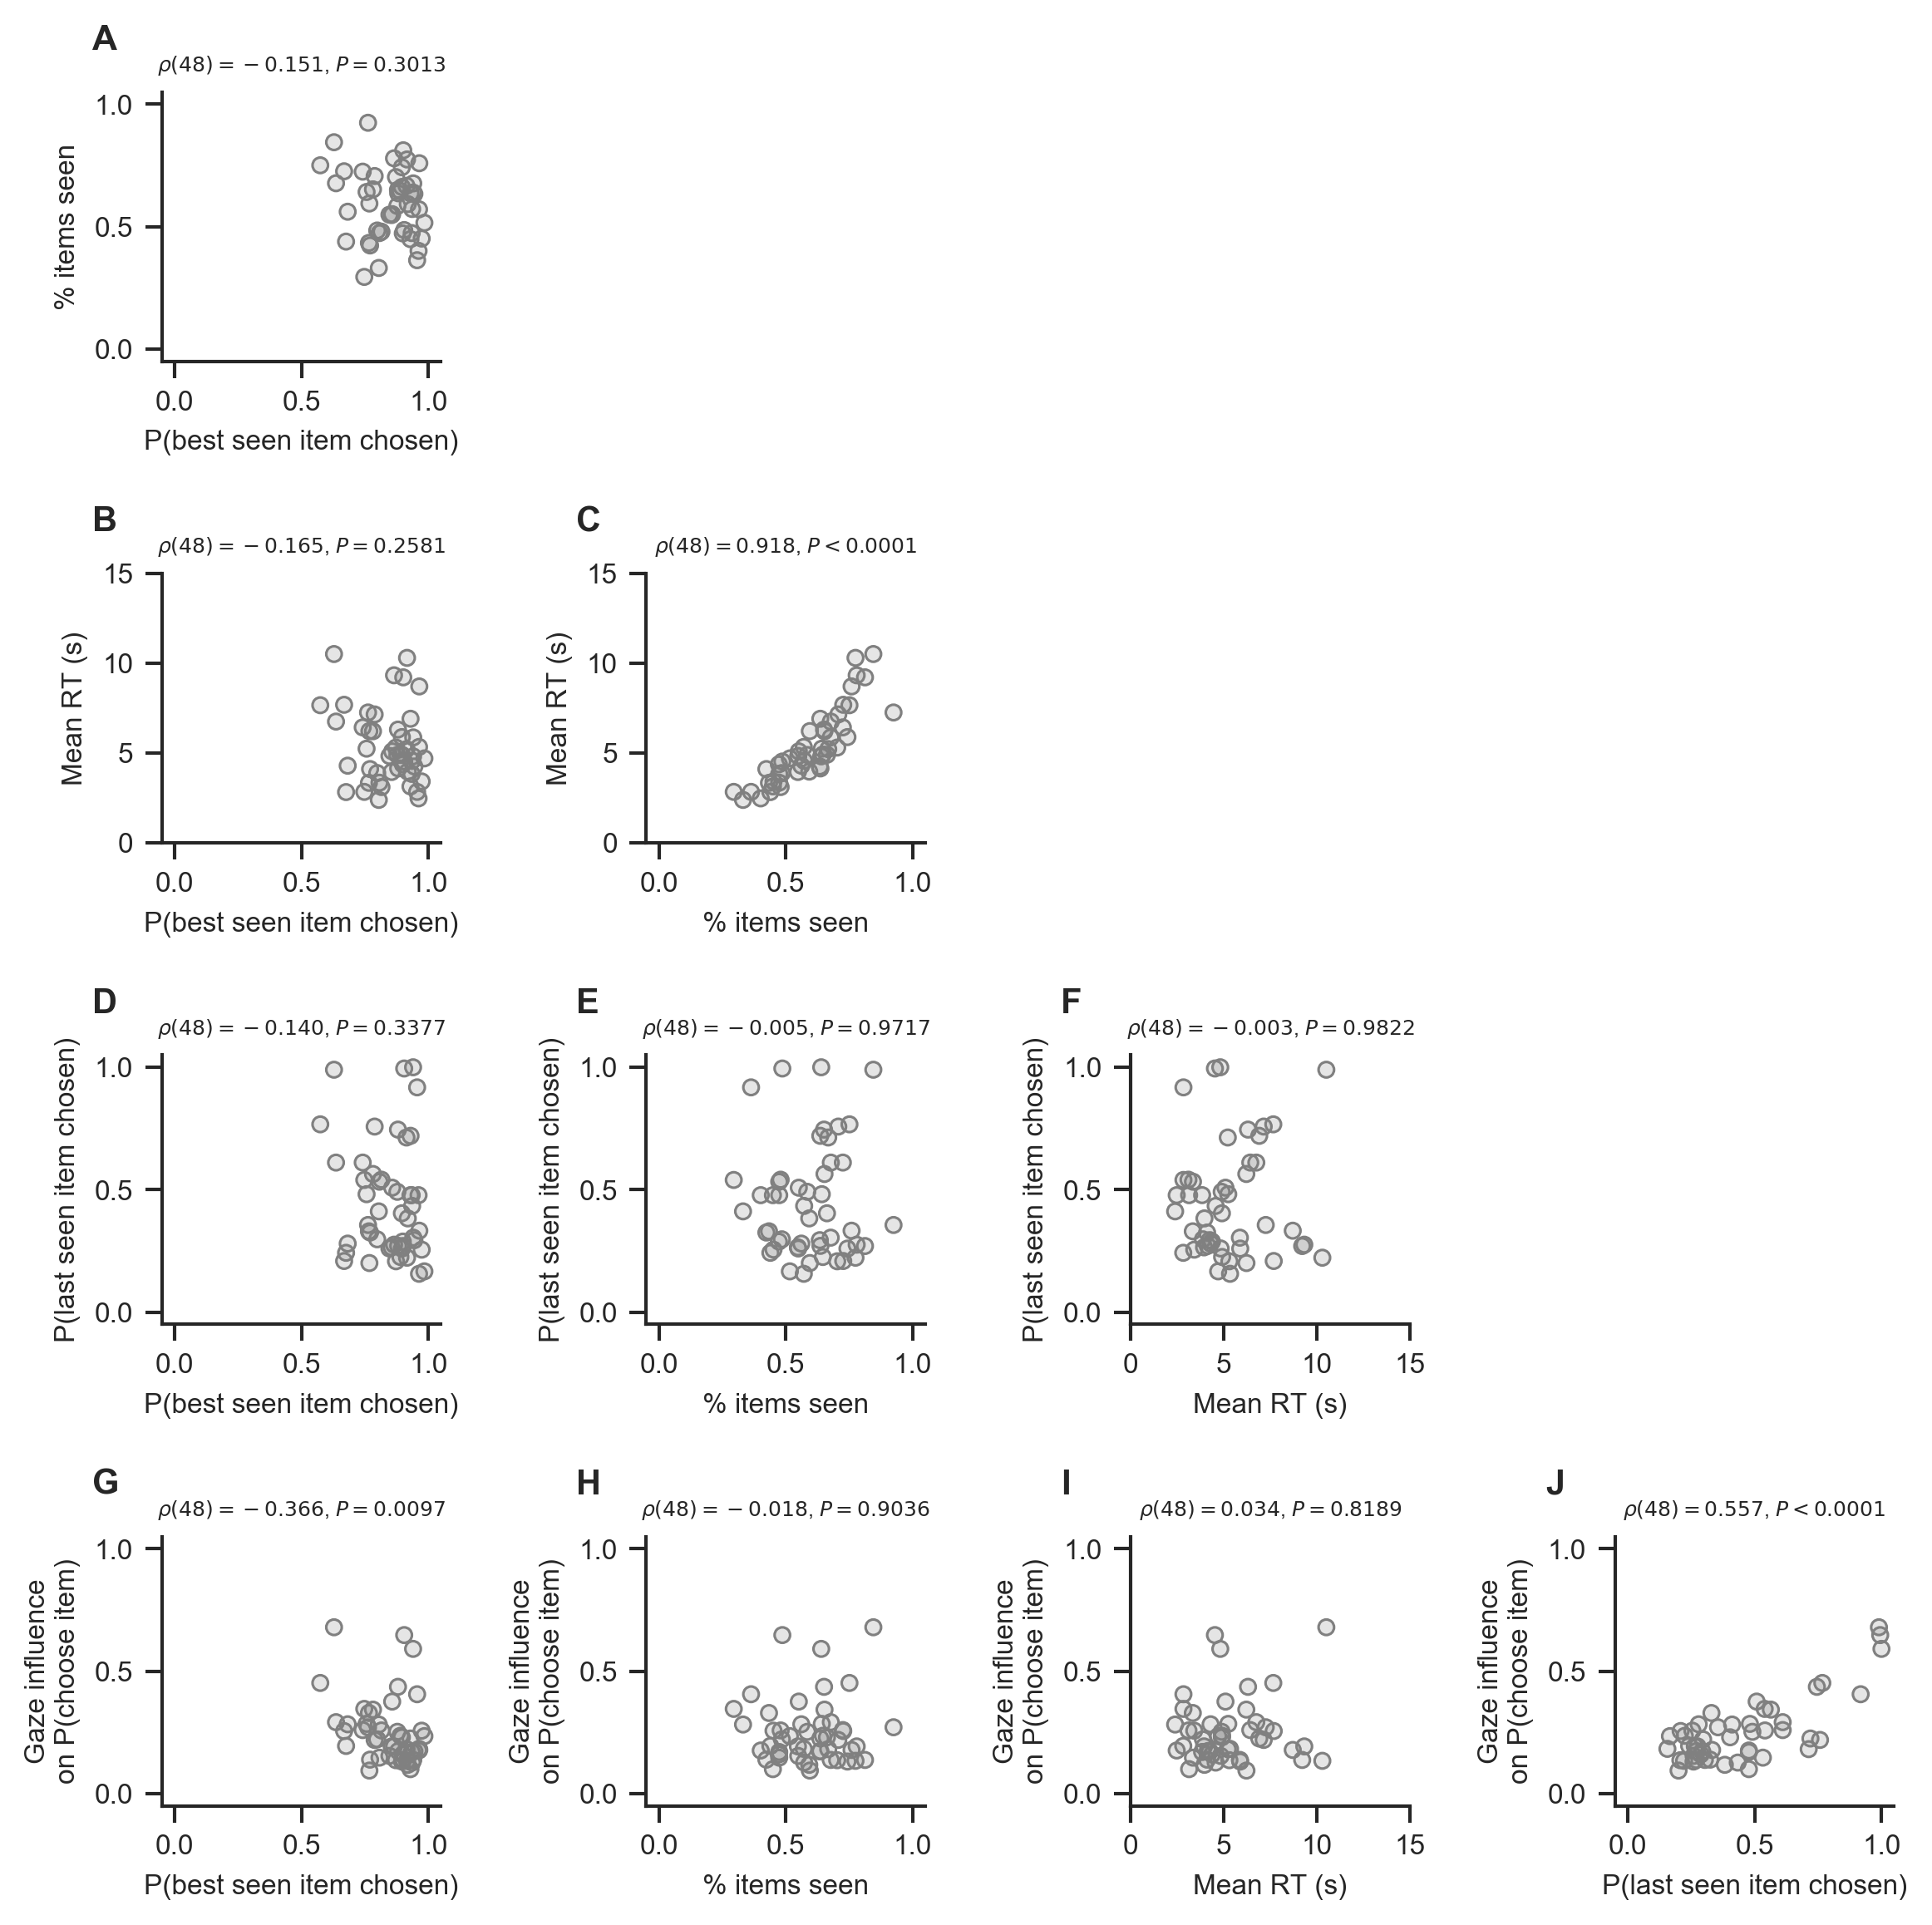

In [9]:
np.random.seed(11)

fig, _ = figure_4_figure_supplement_1(data, gaze_data)
fig.savefig(figure_dir+'Figure-4-figure-supplement-2_choice-psychometrics-associations.pdf', dpi=300)
fig.savefig(figure_dir+'Figure-4-figure-supplement-2_choice-psychometrics-associations.png', dpi=300)
fig.savefig(figure_dir+'Figure-4-figure-supplement-2_choice-psychometrics-associations.jpg', dpi=300)